In [2]:
from src.common import *
from src.houses import *
from src.agents import *
from src.bidding import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

In [3]:
n = 10_000
agents = generate_agents(n)
size = sys.getsizeof(agents)
print(f"The agents array takes up {size} bytes of memory, which is {size/(1024**3):.6f} GB of memory")
print(agents)

The agents array takes up 310112 bytes of memory, which is 0.000289 GB of memory
[(   0,  319540.51441996,  4, 27, False, -1, 0., 0.6268534 )
 (   1,  652514.74521877,  7, 46, False, -1, 0., 0.618406  )
 (   2, 1037652.01112347, 10, 82, False, -1, 0., 0.6634909 ) ...
 (9997,  411934.37745779,  5, 89, False, -1, 0., 0.6753911 )
 (9998,  288912.93304518,  3, 96, False, -1, 0., 0.79473466)
 (9999,  770145.93215543,  8,  9, False, -1, 0., 0.6891418 )]


In [4]:
freq, total = get_freq_and_total(agents)
proportions = get_proportion(freq, total)
agents = check_happiness(agents, proportions)

In [5]:
utility = get_utilities(agents, proportions)
print(utility)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.76751083 0.7917129  0.88551444 ... 0.88864547 0.80784535 0.75472283]
 [0.5467592  0.5227849  0.5160275  ... 0.35630283 0.3216627  0.6226815 ]
 ...
 [0.776857   0.8059676  0.8735532  ... 0.85868174 0.77377903 0.81632346]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.5983137  0.6944359  0.8183316  ... 0.81176883 0.64843047 0.6550376 ]]


In [6]:
bids, neighborhoods_chosen = place_bid(agents, utility)
print(bids)

[     0.         326257.37260938 518826.00556173 ... 205967.18872889
      0.         385072.96607772]


In [7]:
houses = initialize_houses(agents)
print(houses)

[(   0, -1, 51, 100000.) (   1, -1, 42, 100000.) (   2, -1,  9, 100000.)
 ... (9997, -1, 16, 100000.) (9998, -1, 33, 100000.)
 (9999, -1, 84, 100000.)]


In [8]:
agent_house_mapping(agents, houses)
priced_out_mask = check_priced_out(agents, houses, proportions)
evict_priced_out(agents, houses, priced_out_mask)

In [9]:
agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
print(f"Iteration 0: {round(np.mean(agents["happy"])*100,3)}% of agents are happy")
print(f"{round(np.sum(agents["neighborhood"]==-1)*100/n,3)}% of agents are homeless")
print()
# happiness check -> bids -> price update -> assignment -> happiness check
max_iter = 100
count = 1
convergence_count = 0
prev_happy, prev_homeless = 0,0
while not np.all(agents["happy"]):
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)

    utilities = get_utilities(agents, proportions)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    happy_agents = round(np.mean(agents["happy"])*100,3)
    homeless_agents = round(np.sum(agents["neighborhood"]==-1)*100/n,3)
    print(f"Iteration {count}: {happy_agents}% of agents are happy")
    print(f"{homeless_agents}% of agents are homeless")
    print()
    count += 1
    if count >= max_iter:
        break
    """if happy_agents == prev_happy and homeless_agents == prev_homeless:
        convergence_count += 1
        if convergence_count >= 2:
            break # we have converged if both criteria stay the same
    else:
        prev_happy = happy_agents
        prev_homeless = homeless_agents
    if count >= max_iter:
        break"""

# runtime:
# 1 mil agents, not plugged in: 3m 20.9s
# 1 mil agents, plugged in: 2m 40.6s
# 30 mil agents (approx delhi popln): failed to run - out of memory

Iteration 0: 55.84% of agents are happy
0.0% of agents are homeless

Iteration 1: 59.18% of agents are happy
1.15% of agents are homeless

Iteration 2: 56.59% of agents are happy
5.04% of agents are homeless

Iteration 3: 57.79% of agents are happy
4.47% of agents are homeless

Iteration 4: 56.59% of agents are happy
5.32% of agents are homeless

Iteration 5: 57.79% of agents are happy
4.56% of agents are homeless

Iteration 6: 56.59% of agents are happy
5.32% of agents are homeless

Iteration 7: 57.79% of agents are happy
4.56% of agents are homeless

Iteration 8: 56.59% of agents are happy
5.32% of agents are homeless

Iteration 9: 57.79% of agents are happy
4.56% of agents are homeless

Iteration 10: 56.59% of agents are happy
5.32% of agents are homeless

Iteration 11: 57.79% of agents are happy
4.56% of agents are homeless

Iteration 12: 56.59% of agents are happy
5.32% of agents are homeless

Iteration 13: 57.79% of agents are happy
4.56% of agents are homeless

Iteration 14: 56.

In [10]:
for i in range(-1, np.max(agents["neighborhood"]+1)):
    print(f"Neighborhood {i}: {np.sum(agents["neighborhood"]==i)} agents")

Neighborhood -1: 456 agents
Neighborhood 0: 110 agents
Neighborhood 1: 89 agents
Neighborhood 2: 98 agents
Neighborhood 3: 95 agents
Neighborhood 4: 98 agents
Neighborhood 5: 88 agents
Neighborhood 6: 82 agents
Neighborhood 7: 202 agents
Neighborhood 8: 181 agents
Neighborhood 9: 95 agents
Neighborhood 10: 113 agents
Neighborhood 11: 98 agents
Neighborhood 12: 72 agents
Neighborhood 13: 95 agents
Neighborhood 14: 96 agents
Neighborhood 15: 96 agents
Neighborhood 16: 95 agents
Neighborhood 17: 86 agents
Neighborhood 18: 99 agents
Neighborhood 19: 86 agents
Neighborhood 20: 65 agents
Neighborhood 21: 80 agents
Neighborhood 22: 91 agents
Neighborhood 23: 99 agents
Neighborhood 24: 92 agents
Neighborhood 25: 92 agents
Neighborhood 26: 94 agents
Neighborhood 27: 106 agents
Neighborhood 28: 177 agents
Neighborhood 29: 114 agents
Neighborhood 30: 93 agents
Neighborhood 31: 98 agents
Neighborhood 32: 85 agents
Neighborhood 33: 86 agents
Neighborhood 34: 89 agents
Neighborhood 35: 104 agents
Ne

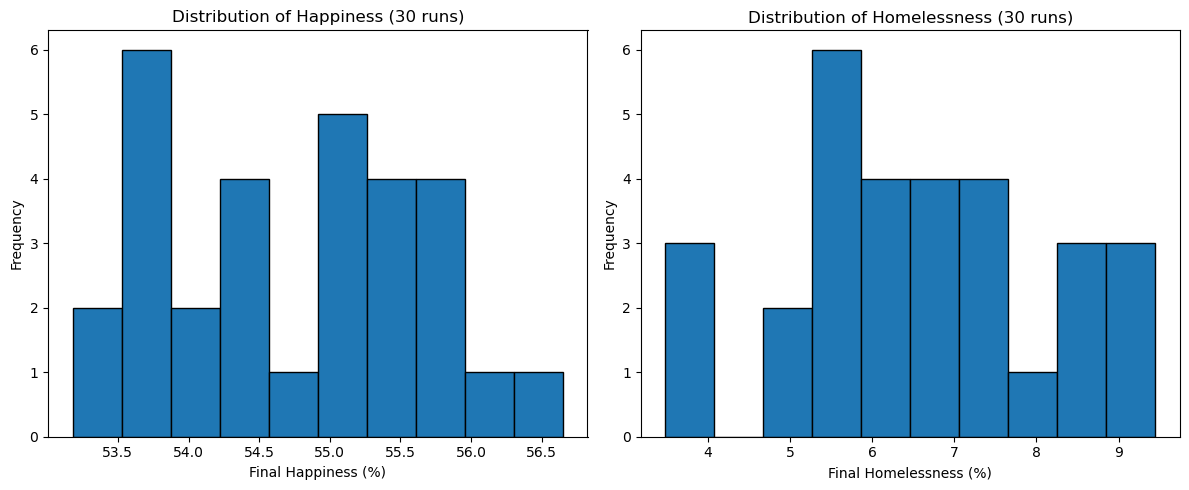

In [11]:
def run_sim(n, max_iter=100):
    # initialize agents and houses fresh each run
    agents = generate_agents(n)
    houses = initialize_houses(agents)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)

    utilities = get_utilities(agents, proportions)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)

    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    count = 1
    while not np.all(agents["happy"]):
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)

        priced_out_mask = check_priced_out(agents, houses, proportions)
        evict_priced_out(agents, houses, priced_out_mask)

        utilities = get_utilities(agents, proportions)
        bids, neighborhoods_chosen = place_bid(agents, utilities)
        agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
        houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
        
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)
        agents = check_happiness(agents, proportions)

        count += 1
        if count >= max_iter:
            break
    
    # collect final stats
    happiness = np.mean(agents["happy"]) * 100
    homelessness = np.sum(agents["neighborhood"] == -1) * 100 / n
    return happiness, homelessness

# Monte Carlo loop
n = 10_000
runs = 30
results = [run_sim(n) for _ in range(runs)]

happiness_vals, homelessness_vals = zip(*results)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(happiness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Happiness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Happiness (30 runs)")

plt.subplot(1,2,2)
plt.hist(homelessness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Homelessness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Homelessness (30 runs)")

plt.tight_layout()
plt.show()

# first run: 76m 18.7s = 4578.7s
# after skipping utility check for happy agents: 71m 16.6s = 4276.6s (~6.6% speedup)

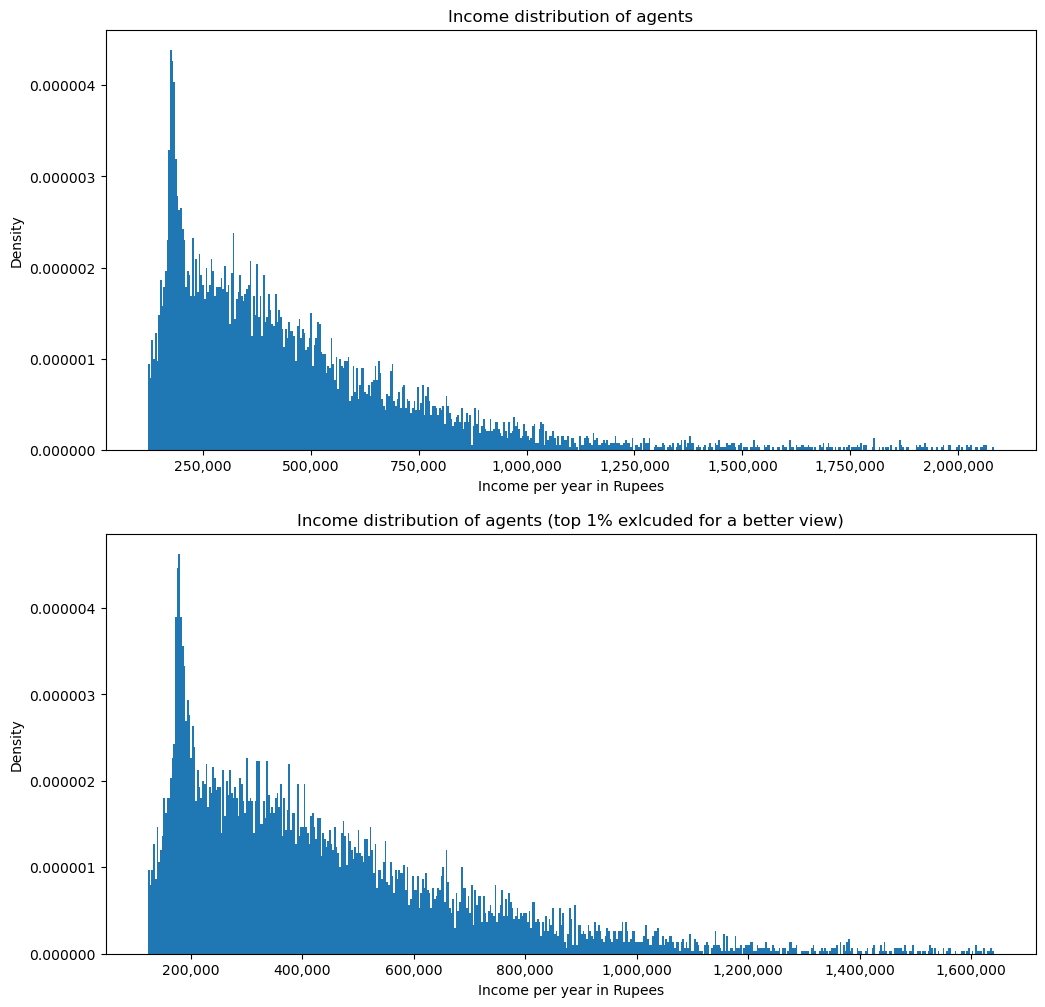

In [12]:
# plot the agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))


# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))

plt.show()